### Infotaxis for Door Localization


In [1]:
import numpy as np 

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
import matplotlib.pyplot as plt

In [2]:
def delta(belief, location, limit, S, x, y, prob): 
    spoof = np.copy(location)
    #update location
    spoof[0] += y
    spoof[1] += x

    #check to make sure that we aren't breaking limits. If we are return a 0 change.
    if (-1 < spoof[0] < limit) != True:
        return 99999999 
    
    if (-1 < spoof[1] < limit) != True:
        return 99999999 
    
    ##Take the hypothetical 1 measurement --------------------------------------------------------
    #Intitialize the LH. 
    # LH = np.copy(prob)

    LH = np.full_like(belief, 0)

    #Update the LH around the current location.
    #Make sure that bounds exist around the robot location.
    LH[tuple(spoof)] = 1
    
    #Assign the probabilites.
    for i in range(1,4):
        #make sure that we are hitting the last row.
        if (spoof[0]+i) < limit:
            for j in range(-i,i+1):
                #make sure we keep in mind the left and right boundary. 
                if -1 < (spoof[1]+j) < limit:
                    #update the upper range of values.
                    LH[spoof[0]+i, spoof[1]+j] = 1/(i+1)
                
        #make sure that we are above 0, so that we don't negative index.        
        if (spoof[0]-i) > -1:
            for j in range(-i,i+1):
                #make sure we keep in mind the left and right boundary. 
                if -1 < (spoof[1]+j) < limit:
                    #update the lower range of values.
                    LH[spoof[0]-i, spoof[1]+j] = 1/(i+1)

    #Assign the probabilties to the rest of locations that are not specified. 
    LH[LH == 0] = 1/100

    #Update our posterior and normalize it. 
    newbelief = np.multiply(LH, belief)/np.sum(np.multiply(LH, belief))

    #Recalculate the entropy of the updated belief for the 1 measurement. 
    S1 = np.sum(np.multiply(np.log(newbelief, where= newbelief>0),newbelief))


    ##Take the hypothetical 0 measurement --------------------------------------------------------
    #Initialize the LH. 
    # LH = np.copy(prob)
    LH = np.full_like(belief, 0)
    
    #Make sure that bounds exist around the robot location.
    #Assign the probabilites.
    for ii in range(1,4):
        #make sure that we are hitting the last row.
        if (spoof[0]+ii) < limit:
            for jj in range(-ii,ii+1):
                #make sure we keep in mind the left and right boundary. 
                if -1 < (spoof[1]+jj) < limit:
                    #update the upper range of values.
                    LH[spoof[0]+ii, spoof[1]+jj] = ii/(ii+1)
                
        #make sure that we are above 0, so that we don't negative index.        
        if (spoof[0]-ii) > -1:
            for jj in range(-ii,ii+1):
                #make sure we keep in mind the left and right boundary. 
                if -1 < (spoof[1]+jj) < limit:
                    #update the lower range of values.
                    LH[spoof[0]-ii, spoof[1]+jj] = ii/(ii+1)

    #Assign the probabilties to the rest of locations that are not specified. 
    LH[LH == 0] = 99/100

    #Update the LH around the current location.
    LH[tuple(spoof)] = 0
    
    #Update our posterior and normalize it. 
    newbelief = np.multiply(LH, belief)/np.sum(np.multiply(LH, belief))

    #Recalculate the entropy of the updated belief for the 1 measurement. 
    S0 = np.sum(np.multiply(np.log(newbelief, where= newbelief>0),newbelief))

    S_weighted = (1 - prob[tuple(spoof)])* S0 + prob[tuple(spoof)] * S1

    return S - S_weighted



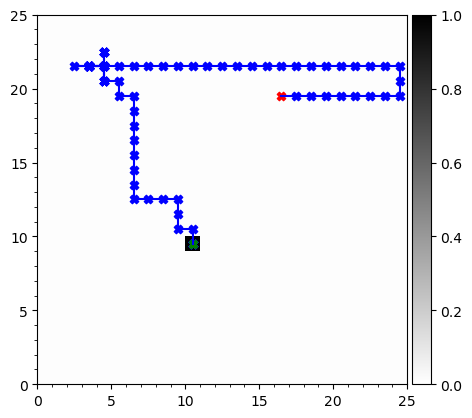

In [12]:
##Problem Initialization -------------------------------------------------------------------------------
#initialize a 25 x 25 matrix. Scalable to larger sizes.
size = 25
locGrid = np.zeros((size,size))             #This is our position grid. 
probGrid = np.full((size,size),1/100)       #This is our probability grid. Serves as our likelihood function.

#door can only be initialized 3 squares from the edges.
doorLoc = (np.random.randint(3, size-3), np.random.randint(3, size-3))

#update probabilites based on door positioning.
probGrid[doorLoc] = 1


##Plots-------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
divider = make_axes_locatable(ax) 

#Creation of the colormap and the colorbar. 
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.pcolormesh(probGrid, cmap='binary', vmin=0, vmax=1)
fig.colorbar(im, cax=cax, orientation='vertical')

#Turn on the grid limits so that it aligns to the pcmesh.
ax.set_xlim(0,size)
ax.set_ylim(0,size)

#Gridlines on both major and minor ticks.
# ax.grid(True, color="black", which="both")
ax.minorticks_on()

#Set the pcmesh to look like a square area.
ax.set_aspect("equal")

for i in range(1,4):
    for j in range(-i,i+1):
        #update the upper range of values.
        probGrid[doorLoc[0]+i, doorLoc[1]+j] = 1/(i+1)
        #update the lower range of values.
        probGrid[doorLoc[0]-i, doorLoc[1]+j] = 1/(i+1)

#robot can be initialized anywhere within the matrix. Update locGrid.
robotLoc = [np.random.randint(0, size), np.random.randint(0, size)]
# robotLoc = [24,15]
locGrid[tuple(doorLoc)] = 1 

ax.scatter(robotLoc[1]+0.5,robotLoc[0]+0.5, color="red", marker="X")

##InfoTaxis Implementation ------------------------------------------------------------------------------
#initialize our prior distribution as a uniform distribution.
priorGrid = np.full((size,size),1/size**2)  

#Empty values are volatile, start with zeros.
postGrid = np.full_like(priorGrid, 0)  

#initialize the entropy of the prior distribution across the environment, S
# S = \Sigma p(x) * log [p(x)]
S = np.sum(np.multiply(np.log(priorGrid),priorGrid))

#Create our directions vector for reference
#stay, north, south, east, west
directions = [(0,0),(1,0),(-1,0),(0,1),(0,-1)]

while abs(S) > 0.1: 
# for k in range(100):
    #Take a measurement of 1 or 0 based on the current location of the robot, with the current probabilities. 
    measurement = np.random.choice([0,1], p=[1 - probGrid[tuple(robotLoc)],probGrid[tuple(robotLoc)]])

    if measurement == 0:
        #Initialize the likelihood. 
        likelihood = np.full_like(probGrid, 0)
        
        #Make sure that bounds exist around the robot location.
        #Assign the probabilites.
        for ii in range(1,4):
            #make sure that we are hitting the last row.
            if (robotLoc[0]+ii) < size:
                for jj in range(-ii,ii+1):
                    #make sure we keep in mind the left and right boundary. 
                    if -1 < (robotLoc[1]+jj) < size:
                        #update the upper range of values.
                        likelihood[robotLoc[0]+ii, robotLoc[1]+jj] = ii/(ii+1)
                    
            #make sure that we are above 0, so that we don't negative index.        
            if (robotLoc[0]-ii) > -1:
                for jj in range(-ii,ii+1):
                    #make sure we keep in mind the left and right boundary. 
                    if -1 < (robotLoc[1]+jj) < size:
                        #update the lower range of values.
                        likelihood[robotLoc[0]-ii, robotLoc[1]+jj] = ii/(ii+1)

        #Assign the probabilties to the rest of locations that are not specified. 
        likelihood[likelihood == 0] = 99/100

        #Update the likelihood around the current location.
        likelihood[tuple(robotLoc)] = 0

    else:
        #Intitialize the likelihood. 
        likelihood = np.full_like(probGrid,0)

        #Update the likelihood around the current location.
        #Make sure that bounds exist around the robot location.
        likelihood[tuple(robotLoc)] = 1
        
        #Assign the probabilites.
        for ii in range(1,4):
            #make sure that we are hitting the last row.
            if (robotLoc[0]+ii) < size:
                for jj in range(-ii,ii+1):
                    #make sure we keep in mind the left and right boundary. 
                    if -1 < (robotLoc[1]+jj) < size:
                        #update the upper range of values.
                        likelihood[robotLoc[0]+ii, robotLoc[1]+jj] = 1/(ii+1)
                    
            #make sure that we are above 0, so that we don't negative index.        
            if (robotLoc[0]-ii) > -1:
                for jj in range(-ii,ii+1):
                    #make sure we keep in mind the left and right boundary. 
                    if -1 < (robotLoc[1]+jj) < size:
                        #update the lower range of values.
                        likelihood[robotLoc[0]-ii, robotLoc[1]+jj] = 1/(ii+1)

        #Assign the probabilties to the rest of locations that are not specified. 
        likelihood[likelihood == 0] = 1/100

    #Update our posterior and normalize it. 
    postGrid = np.multiply(likelihood, priorGrid)/np.sum(np.multiply(likelihood, priorGrid))

    #Recalculate the entropy of the updated belief.
    S = np.sum(np.multiply(np.log(postGrid, where=postGrid>0),postGrid))

    #Calculate which of the 5 directions will cause the largest decrease in entropy. 
    stay    = delta(postGrid, robotLoc, size, S,  0,  0, probGrid)
    north   = delta(postGrid, robotLoc, size, S,  0,  1, probGrid)
    south   = delta(postGrid, robotLoc, size, S,  0, -1, probGrid)
    east    = delta(postGrid, robotLoc, size, S,  1,  0, probGrid)
    west    = delta(postGrid, robotLoc, size, S, -1,  0, probGrid)

    #update the prior. 
    priorGrid = np.copy(postGrid)

    #move in the direction that causes the biggest change in entropy reduction.
    index = np.argmin([stay, north, south, east, west])

    #plot the line 
    ax.plot([robotLoc[1]+0.5, robotLoc[1]+0.5 + directions[index][1]],
            [robotLoc[0]+0.5, robotLoc[0]+0.5 + directions[index][0]], color="blue")

    robotLoc[0] += directions[index][0]
    robotLoc[1] += directions[index][1]

    ax.scatter(robotLoc[1]+0.5,robotLoc[0]+0.5, color="blue", marker="X")

ax.scatter(robotLoc[1]+0.5,robotLoc[0]+0.5, color="green", marker="X")


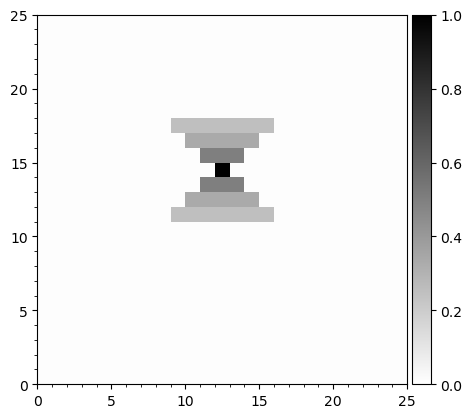

In [4]:
##Plots-------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
divider = make_axes_locatable(ax) 

#Creation of the colormap and the colorbar. 
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.pcolormesh(likelihood, cmap='binary', vmin=0, vmax=1)
fig.colorbar(im, cax=cax, orientation='vertical')

#Turn on the grid limits so that it aligns to the pcmesh.
ax.set_xlim(0,size)
ax.set_ylim(0,size)

#Gridlines on both major and minor ticks.
# ax.grid(True, color="black", which="both")
ax.minorticks_on()

#Set the pcmesh to look like a square area.
ax.set_aspect("equal")


# ax.plot([0.5, 1.5], [0.5, 1.5], marker="X")

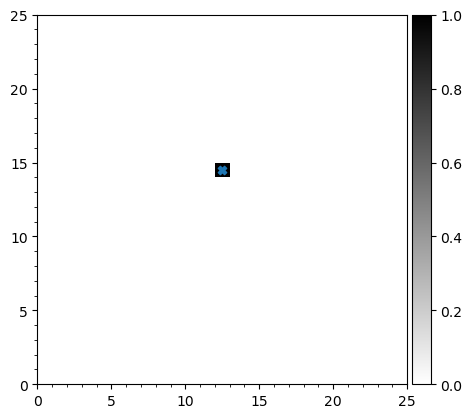

In [5]:
##Plots-------------------------------------------------------------------------------------------------
fig, ax = plt.subplots()
divider = make_axes_locatable(ax) 

#Creation of the colormap and the colorbar. 
cax = divider.append_axes('right', size='5%', pad=0.05)
#im = ax.pcolormesh(postGrid, cmap='binary', vmax=1, vmin=0)
im = ax.pcolormesh(locGrid, cmap='binary')
fig.colorbar(im, cax=cax, orientation='vertical')

#Turn on the grid limits so that it aligns to the pcmesh.
ax.set_xlim(0,size)
ax.set_ylim(0,size)

#Gridlines on both major and minor ticks.
# ax.grid(True, color="black", which="both")
ax.minorticks_on()

#Set the pcmesh to look like a square area.
ax.set_aspect("equal")

ax.scatter(robotLoc[1] + 0.5 , robotLoc[0] + 0.5, marker="X")